In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
import helper
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report,accuracy_score
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

balanced_path_data = 'drive/MyDrive/balanced_csic_data_64/training'
#imbalanced_path_data = 'drive/MyDrive/imbalanced_csic_data_64/training'

feature_extract = True

In [ ]:
mean = torch.tensor([135.31470632, 124.53849418, 103.39646082])
std = torch.tensor([5.18153318, 4.14170719, 5.17011963])

# transform = transforms.Compose([transforms.Resize(255),
#                                 transforms.CenterCrop(224),
#                                 transforms.ToTensor(),
#                                 transforms.RandomRotation(degrees=360),
#                                 transforms.RandomHorizontalFlip(p=0.5),
#                                 transforms.ColorJitter(brightness=.5, hue=.3),
#                                 transforms.RandomInvert(),
#                                 transforms.Normalize(mean, std)])


transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

In [ ]:
def train_val_dataset(dataset, val_split=0.1):
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

# load the balanced dataset
balanced_dataset = datasets.ImageFolder(balanced_path_data, transform=transform)
balanced_datasets = train_val_dataset(balanced_dataset)

# #load the imbalanced dataset
# imbalanced_dataset = datasets.ImageFolder(imbalanced_path_data, transform=transform)
# imbalanced_datasets = train_val_dataset(imbalanced_dataset)

class_dict = balanced_dataset.class_to_idx


In [ ]:
batch_size = 32
balanced_dataloaders_dict = {x: torch.utils.data.DataLoader(balanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}
#imbalanced_dataloaders_dict = {x: torch.utils.data.DataLoader(imbalanced_datasets[x], batch_size=batch_size, shuffle=True, num_workers=2) for x in ['train', 'val']}


In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False


In [ ]:
# balanced_data_iter = iter(balanced_dataloaders_dict['train'])
# images, labels = next(balanced_data_iter)

# imbalanced_data_iter = iter(imbalanced_dataloaders_dict['train'])
# images, labels = next(imbalanced_data_iter)

In [ ]:
from tqdm import trange
from tqdm import tqdm

In [ ]:
# def getCategoricalAccuracy(pred, true, class_names:dict):
#   for cl in class_names.keys():
#     class_id = int(class_names[cl])
#     locs = np.where(np.array(true)==class_id)
#     class_acc = sum(pred[locs] == int(class_id))/len(locs)
#     print('Accuracy for {}:{}'.format(str(cl), class_acc))

def train_model(model, dataloaders, criterion, optimizer,num_epochs=20, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase],unit = 'batch') as tepoch:
              # Iterate over data.
              for inputs, labels in tepoch:
                  inputs = inputs.to(device)
                  labels = labels.to(device)

                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train
                  with torch.set_grad_enabled(phase == 'train'):
                      # Get model outputs and calculate loss
                      # Special case for inception because in training it has an auxiliary output. In train
                      #   mode we calculate the loss by summing the final output and the auxiliary output
                      #   but in testing we only consider the final output.
                      if is_inception and phase == 'train':
                          # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                          outputs, aux_outputs = model(inputs)
                          loss1 = criterion(outputs, labels)
                          loss2 = criterion(aux_outputs, labels)
                          loss = loss1 + 0.4*loss2
                      else:
                          outputs = model(inputs)
                          loss = criterion(outputs, labels)

                      _, preds = torch.max(outputs, 1)
                      

                      # backward + optimize only if in training phase
                      if phase == 'train':
                          loss.backward()
                          optimizer.step()
                      

                  # statistics
                  running_loss += loss.item() * inputs.size(0)
                  #getCategoricalAccuracy(preds, labels.data, class_dict)
                  running_corrects += torch.sum(preds == labels.data)

              epoch_loss = running_loss / len(dataloaders[phase].dataset)
              epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

              print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

              # deep copy the model
              if phase == 'val' and epoch_acc > best_acc:
                  best_acc = epoch_acc
                  best_model_wts = copy.deepcopy(model.state_dict())
              if phase == 'val':
                  val_acc_history.append(epoch_acc)
              if phase == 'train':
                  train_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history

In [ ]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
# Setup the loss fxn
import time
import copy
criterion = nn.CrossEntropyLoss()
epoch = 100

In [ ]:
# ResNet 18
model_ft_balanced = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ft_balanced, True)
model_ft_balanced.fc = nn.Linear(512, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced = model_ft_balanced.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet18 on a balanced dataset
model_ft_balanced, balanced_val_hist, balanced_tr_hist  = train_model(model_ft_balanced, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/99
----------


100%|██████████| 94/94 [17:04<00:00, 10.89s/batch]


train Loss: 1.0773 Acc: 0.4535


100%|██████████| 11/11 [01:54<00:00, 10.44s/batch]


val Loss: 1.0268 Acc: 0.4940

Epoch 1/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.31batch/s]


train Loss: 1.0512 Acc: 0.4722


100%|██████████| 11/11 [00:04<00:00,  2.33batch/s]


val Loss: 1.0111 Acc: 0.5361

Epoch 2/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.31batch/s]


train Loss: 1.0431 Acc: 0.4722


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 1.0049 Acc: 0.4880

Epoch 3/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 1.0301 Acc: 0.4926


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.9761 Acc: 0.5422

Epoch 4/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 1.0237 Acc: 0.4946


100%|██████████| 11/11 [00:04<00:00,  2.35batch/s]


val Loss: 0.9724 Acc: 0.5331

Epoch 5/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 1.0142 Acc: 0.5100


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.9651 Acc: 0.5482

Epoch 6/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 1.0103 Acc: 0.5114


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.9595 Acc: 0.5331

Epoch 7/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.21batch/s]


train Loss: 1.0077 Acc: 0.5224


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.9723 Acc: 0.5542

Epoch 8/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9989 Acc: 0.5375


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.9599 Acc: 0.5602

Epoch 9/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9960 Acc: 0.5428


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.9559 Acc: 0.5813

Epoch 10/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9967 Acc: 0.5331


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.9597 Acc: 0.5693

Epoch 11/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9895 Acc: 0.5502


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.9458 Acc: 0.5843

Epoch 12/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.32batch/s]


train Loss: 0.9900 Acc: 0.5562


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.9414 Acc: 0.6145

Epoch 13/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.21batch/s]


train Loss: 0.9809 Acc: 0.5499


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.9402 Acc: 0.5904

Epoch 14/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9779 Acc: 0.5579


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9389 Acc: 0.5964

Epoch 15/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9748 Acc: 0.5596


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9462 Acc: 0.5693

Epoch 16/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9788 Acc: 0.5519


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9442 Acc: 0.5964

Epoch 17/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.40batch/s]


train Loss: 0.9715 Acc: 0.5599


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.9362 Acc: 0.6235

Epoch 18/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9755 Acc: 0.5589


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9287 Acc: 0.5964

Epoch 19/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9726 Acc: 0.5586


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.9308 Acc: 0.6205

Epoch 20/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.29batch/s]


train Loss: 0.9669 Acc: 0.5683


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9267 Acc: 0.6054

Epoch 21/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9704 Acc: 0.5499


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9435 Acc: 0.5783

Epoch 22/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9656 Acc: 0.5659


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9201 Acc: 0.6145

Epoch 23/99
----------


100%|██████████| 94/94 [00:38<00:00,  2.41batch/s]


train Loss: 0.9665 Acc: 0.5693


100%|██████████| 11/11 [00:04<00:00,  2.40batch/s]


val Loss: 0.9099 Acc: 0.6446

Epoch 24/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9623 Acc: 0.5713


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9185 Acc: 0.5813

Epoch 25/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.40batch/s]


train Loss: 0.9566 Acc: 0.5760


100%|██████████| 11/11 [00:04<00:00,  2.43batch/s]


val Loss: 0.9109 Acc: 0.6114

Epoch 26/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.39batch/s]


train Loss: 0.9625 Acc: 0.5609


100%|██████████| 11/11 [00:04<00:00,  2.40batch/s]


val Loss: 0.9100 Acc: 0.5994

Epoch 27/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.31batch/s]


train Loss: 0.9569 Acc: 0.5730


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.9445 Acc: 0.5693

Epoch 28/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9672 Acc: 0.5552


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.9206 Acc: 0.5843

Epoch 29/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9510 Acc: 0.5763


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.8938 Acc: 0.6175

Epoch 30/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9526 Acc: 0.5776


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.9174 Acc: 0.6024

Epoch 31/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9533 Acc: 0.5773


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.9143 Acc: 0.6054

Epoch 32/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9549 Acc: 0.5686


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.9099 Acc: 0.6205

Epoch 33/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9403 Acc: 0.5914


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.9114 Acc: 0.6024

Epoch 34/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9501 Acc: 0.5853


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.9094 Acc: 0.6175

Epoch 35/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9552 Acc: 0.5766


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.8957 Acc: 0.6295

Epoch 36/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9487 Acc: 0.5810


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.9030 Acc: 0.5964

Epoch 37/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9526 Acc: 0.5776


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.8774 Acc: 0.6235

Epoch 38/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9512 Acc: 0.5763


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.9050 Acc: 0.6084

Epoch 39/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9388 Acc: 0.5884


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.9031 Acc: 0.5964

Epoch 40/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9380 Acc: 0.5870


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.9096 Acc: 0.5994

Epoch 41/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9482 Acc: 0.5736


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.9065 Acc: 0.5964

Epoch 42/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9406 Acc: 0.5877


100%|██████████| 11/11 [00:04<00:00,  2.35batch/s]


val Loss: 0.8883 Acc: 0.6295

Epoch 43/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.34batch/s]


train Loss: 0.9427 Acc: 0.5924


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.9167 Acc: 0.5964

Epoch 44/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.35batch/s]


train Loss: 0.9428 Acc: 0.5773


100%|██████████| 11/11 [00:04<00:00,  2.35batch/s]


val Loss: 0.8806 Acc: 0.6175

Epoch 45/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.35batch/s]


train Loss: 0.9383 Acc: 0.5920


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.8755 Acc: 0.6476

Epoch 46/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.33batch/s]


train Loss: 0.9474 Acc: 0.5673


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.8756 Acc: 0.6325

Epoch 47/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.35batch/s]


train Loss: 0.9356 Acc: 0.5964


100%|██████████| 11/11 [00:04<00:00,  2.35batch/s]


val Loss: 0.8934 Acc: 0.6325

Epoch 48/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9417 Acc: 0.5793


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.8957 Acc: 0.6114

Epoch 49/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.35batch/s]


train Loss: 0.9339 Acc: 0.5917


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8743 Acc: 0.6235

Epoch 50/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.35batch/s]


train Loss: 0.9407 Acc: 0.5770


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.8976 Acc: 0.6054

Epoch 51/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.32batch/s]


train Loss: 0.9341 Acc: 0.5954


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.8908 Acc: 0.6175

Epoch 52/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.35batch/s]


train Loss: 0.9431 Acc: 0.5857


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.8804 Acc: 0.6114

Epoch 53/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.35batch/s]


train Loss: 0.9369 Acc: 0.5843


100%|██████████| 11/11 [00:04<00:00,  2.38batch/s]


val Loss: 0.8787 Acc: 0.5964

Epoch 54/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.35batch/s]


train Loss: 0.9283 Acc: 0.5930


100%|██████████| 11/11 [00:06<00:00,  1.79batch/s]


val Loss: 0.8848 Acc: 0.6114

Epoch 55/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9345 Acc: 0.5994


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.8869 Acc: 0.6295

Epoch 56/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9311 Acc: 0.5887


100%|██████████| 11/11 [00:04<00:00,  2.36batch/s]


val Loss: 0.9146 Acc: 0.6024

Epoch 57/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9455 Acc: 0.5723


100%|██████████| 11/11 [00:04<00:00,  2.40batch/s]


val Loss: 0.8912 Acc: 0.6054

Epoch 58/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9364 Acc: 0.5797


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.8641 Acc: 0.6657

Epoch 59/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.36batch/s]


train Loss: 0.9208 Acc: 0.6007


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.8697 Acc: 0.6325

Epoch 60/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9276 Acc: 0.5910


100%|██████████| 11/11 [00:04<00:00,  2.37batch/s]


val Loss: 0.8936 Acc: 0.6114

Epoch 61/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9247 Acc: 0.5863


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.8633 Acc: 0.6416

Epoch 62/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9218 Acc: 0.5950


100%|██████████| 11/11 [00:04<00:00,  2.40batch/s]


val Loss: 0.8725 Acc: 0.6295

Epoch 63/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9242 Acc: 0.6004


100%|██████████| 11/11 [00:04<00:00,  2.42batch/s]


val Loss: 0.8567 Acc: 0.6536

Epoch 64/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.37batch/s]


train Loss: 0.9159 Acc: 0.6044


100%|██████████| 11/11 [00:04<00:00,  2.41batch/s]


val Loss: 0.8786 Acc: 0.6566

Epoch 65/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.38batch/s]


train Loss: 0.9355 Acc: 0.5917


100%|██████████| 11/11 [00:04<00:00,  2.39batch/s]


val Loss: 0.8729 Acc: 0.6175

Epoch 66/99
----------


100%|██████████| 94/94 [00:39<00:00,  2.35batch/s]


train Loss: 0.9212 Acc: 0.5981


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.8503 Acc: 0.6657

Epoch 67/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.32batch/s]


train Loss: 0.9270 Acc: 0.5920


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8864 Acc: 0.6054

Epoch 68/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.21batch/s]


train Loss: 0.9239 Acc: 0.5884


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.8831 Acc: 0.6355

Epoch 69/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9367 Acc: 0.5900


100%|██████████| 11/11 [00:04<00:00,  2.33batch/s]


val Loss: 0.8691 Acc: 0.6355

Epoch 70/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9245 Acc: 0.5934


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.8602 Acc: 0.6325

Epoch 71/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9258 Acc: 0.5981


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.8743 Acc: 0.6476

Epoch 72/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9167 Acc: 0.6061


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.9028 Acc: 0.6265

Epoch 73/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9128 Acc: 0.6024


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8807 Acc: 0.6084

Epoch 74/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9212 Acc: 0.6011


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8883 Acc: 0.6145

Epoch 75/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.21batch/s]


train Loss: 0.9130 Acc: 0.6098


100%|██████████| 11/11 [00:04<00:00,  2.34batch/s]


val Loss: 0.8818 Acc: 0.6084

Epoch 76/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9283 Acc: 0.5853


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8663 Acc: 0.6506

Epoch 77/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9177 Acc: 0.5994


100%|██████████| 11/11 [00:04<00:00,  2.33batch/s]


val Loss: 0.8737 Acc: 0.6265

Epoch 78/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9209 Acc: 0.6031


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.8683 Acc: 0.6416

Epoch 79/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9141 Acc: 0.6101


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8839 Acc: 0.6205

Epoch 80/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9227 Acc: 0.5991


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8435 Acc: 0.6747

Epoch 81/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9212 Acc: 0.5947


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8943 Acc: 0.5843

Epoch 82/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.21batch/s]


train Loss: 0.9150 Acc: 0.6064


100%|██████████| 11/11 [00:04<00:00,  2.33batch/s]


val Loss: 0.8812 Acc: 0.6325

Epoch 83/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.29batch/s]


train Loss: 0.9209 Acc: 0.5974


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8994 Acc: 0.6145

Epoch 84/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.29batch/s]


train Loss: 0.9240 Acc: 0.6037


100%|██████████| 11/11 [00:04<00:00,  2.35batch/s]


val Loss: 0.8963 Acc: 0.6235

Epoch 85/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9251 Acc: 0.5940


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8691 Acc: 0.6416

Epoch 86/99
----------


100%|██████████| 94/94 [00:40<00:00,  2.30batch/s]


train Loss: 0.9235 Acc: 0.5817


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.8638 Acc: 0.6386

Epoch 87/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9186 Acc: 0.6098


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8941 Acc: 0.6235

Epoch 88/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.20batch/s]


train Loss: 0.9072 Acc: 0.6078


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.8560 Acc: 0.6205

Epoch 89/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9167 Acc: 0.6088


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8891 Acc: 0.6205

Epoch 90/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.9220 Acc: 0.5940


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8580 Acc: 0.6536

Epoch 91/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9168 Acc: 0.5961


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8851 Acc: 0.6205

Epoch 92/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.9142 Acc: 0.5994


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.8836 Acc: 0.6145

Epoch 93/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.9173 Acc: 0.6007


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8602 Acc: 0.6416

Epoch 94/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.9186 Acc: 0.6041


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.8720 Acc: 0.6295

Epoch 95/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.17batch/s]


train Loss: 0.9239 Acc: 0.6017


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8632 Acc: 0.6476

Epoch 96/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.9070 Acc: 0.6044


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8452 Acc: 0.6717

Epoch 97/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9203 Acc: 0.5967


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8723 Acc: 0.5934

Epoch 98/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9131 Acc: 0.6007


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8774 Acc: 0.6355

Epoch 99/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9161 Acc: 0.6027


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]

val Loss: 0.8572 Acc: 0.6536

Training complete in 93m 44s
Best val Acc: 0.674699


In [ ]:
#ResNet 50
model_ft_balanced2 = models.resnet50(pretrained=True)
set_parameter_requires_grad(model_ft_balanced2, True)
model_ft_balanced2.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced2 = model_ft_balanced2.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced2.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced2.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced2, balanced_val_hist2, balanced_tr_hist2  = train_model(model_ft_balanced2, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 1.0644 Acc: 0.4869


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.9775 Acc: 0.5361

Epoch 1/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.20batch/s]


train Loss: 1.0131 Acc: 0.5288


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.9794 Acc: 0.5542

Epoch 2/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.9982 Acc: 0.5405


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.9460 Acc: 0.6175

Epoch 3/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.9817 Acc: 0.5699


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.9365 Acc: 0.6355

Epoch 4/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.9761 Acc: 0.5636


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.9375 Acc: 0.6084

Epoch 5/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9654 Acc: 0.5850


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.9285 Acc: 0.6175

Epoch 6/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.9584 Acc: 0.5897


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.9049 Acc: 0.6145

Epoch 7/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.24batch/s]


train Loss: 0.9408 Acc: 0.6175


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.9004 Acc: 0.6265

Epoch 8/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.19batch/s]


train Loss: 0.9377 Acc: 0.6135


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.9019 Acc: 0.6386

Epoch 9/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.9351 Acc: 0.6004


100%|██████████| 11/11 [00:04<00:00,  2.32batch/s]


val Loss: 0.8673 Acc: 0.6386

Epoch 10/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9240 Acc: 0.6094


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8849 Acc: 0.6114

Epoch 11/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.9341 Acc: 0.6061


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8786 Acc: 0.6295

Epoch 12/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.9160 Acc: 0.6222


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8697 Acc: 0.6295

Epoch 13/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.9031 Acc: 0.6319


100%|██████████| 11/11 [00:04<00:00,  2.33batch/s]


val Loss: 0.8611 Acc: 0.6355

Epoch 14/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.20batch/s]


train Loss: 0.9100 Acc: 0.6252


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8566 Acc: 0.5873

Epoch 15/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.9030 Acc: 0.6235


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8489 Acc: 0.6807

Epoch 16/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.9059 Acc: 0.6278


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8588 Acc: 0.6416

Epoch 17/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.29batch/s]


train Loss: 0.8918 Acc: 0.6342


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8451 Acc: 0.6416

Epoch 18/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.8920 Acc: 0.6305


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.8488 Acc: 0.6596

Epoch 19/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.28batch/s]


train Loss: 0.8819 Acc: 0.6399


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8549 Acc: 0.6295

Epoch 20/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8736 Acc: 0.6422


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8166 Acc: 0.6627

Epoch 21/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.20batch/s]


train Loss: 0.8745 Acc: 0.6382


100%|██████████| 11/11 [00:04<00:00,  2.30batch/s]


val Loss: 0.8536 Acc: 0.6145

Epoch 22/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.17batch/s]


train Loss: 0.8840 Acc: 0.6201


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8554 Acc: 0.6416

Epoch 23/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8819 Acc: 0.6332


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8104 Acc: 0.6566

Epoch 24/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.8690 Acc: 0.6419


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8333 Acc: 0.6536

Epoch 25/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8823 Acc: 0.6406


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8298 Acc: 0.6627

Epoch 26/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.8639 Acc: 0.6432


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.8551 Acc: 0.6325

Epoch 27/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.19batch/s]


train Loss: 0.8745 Acc: 0.6329


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.8331 Acc: 0.6536

Epoch 28/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.8526 Acc: 0.6526


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8300 Acc: 0.6807

Epoch 29/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8667 Acc: 0.6412


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8091 Acc: 0.6476

Epoch 30/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8587 Acc: 0.6466


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8040 Acc: 0.6807

Epoch 31/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.27batch/s]


train Loss: 0.8727 Acc: 0.6248


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7891 Acc: 0.6596

Epoch 32/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8558 Acc: 0.6429


100%|██████████| 11/11 [00:04<00:00,  2.31batch/s]


val Loss: 0.8093 Acc: 0.6416

Epoch 33/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8724 Acc: 0.6285


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7994 Acc: 0.6657

Epoch 34/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.19batch/s]


train Loss: 0.8668 Acc: 0.6349


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.8140 Acc: 0.6717

Epoch 35/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8651 Acc: 0.6439


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.8282 Acc: 0.6506

Epoch 36/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8462 Acc: 0.6560


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.7911 Acc: 0.6747

Epoch 37/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8622 Acc: 0.6402


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7890 Acc: 0.6476

Epoch 38/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8336 Acc: 0.6610


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.7993 Acc: 0.6416

Epoch 39/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8455 Acc: 0.6553


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7886 Acc: 0.6898

Epoch 40/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.16batch/s]


train Loss: 0.8452 Acc: 0.6550


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7853 Acc: 0.6566

Epoch 41/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8353 Acc: 0.6513


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.7768 Acc: 0.6566

Epoch 42/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8548 Acc: 0.6429


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.8276 Acc: 0.6446

Epoch 43/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8511 Acc: 0.6449


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.8043 Acc: 0.6687

Epoch 44/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8316 Acc: 0.6593


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7867 Acc: 0.6476

Epoch 45/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8439 Acc: 0.6463


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7995 Acc: 0.6657

Epoch 46/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8376 Acc: 0.6590


100%|██████████| 11/11 [00:06<00:00,  1.72batch/s]


val Loss: 0.7537 Acc: 0.6898

Epoch 47/99
----------


100%|██████████| 94/94 [00:44<00:00,  2.12batch/s]


train Loss: 0.8412 Acc: 0.6452


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.8236 Acc: 0.6386

Epoch 48/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.20batch/s]


train Loss: 0.8402 Acc: 0.6533


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.7828 Acc: 0.6747

Epoch 49/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8536 Acc: 0.6550


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8100 Acc: 0.6687

Epoch 50/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8335 Acc: 0.6593


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7965 Acc: 0.6657

Epoch 51/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8283 Acc: 0.6539


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7802 Acc: 0.6717

Epoch 52/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.24batch/s]


train Loss: 0.8386 Acc: 0.6452


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.7906 Acc: 0.6747

Epoch 53/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.16batch/s]


train Loss: 0.8296 Acc: 0.6603


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7798 Acc: 0.6386

Epoch 54/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8340 Acc: 0.6496


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7997 Acc: 0.6476

Epoch 55/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8312 Acc: 0.6616


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.7665 Acc: 0.6807

Epoch 56/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8229 Acc: 0.6710


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.8081 Acc: 0.6386

Epoch 57/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8341 Acc: 0.6566


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7680 Acc: 0.6837

Epoch 58/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8250 Acc: 0.6570


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7714 Acc: 0.6898

Epoch 59/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.17batch/s]


train Loss: 0.8220 Acc: 0.6596


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7916 Acc: 0.6687

Epoch 60/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8253 Acc: 0.6653


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7954 Acc: 0.6596

Epoch 61/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8324 Acc: 0.6509


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.8093 Acc: 0.6506

Epoch 62/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8219 Acc: 0.6613


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7698 Acc: 0.6717

Epoch 63/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8300 Acc: 0.6590


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.8040 Acc: 0.6627

Epoch 64/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8304 Acc: 0.6516


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7908 Acc: 0.6566

Epoch 65/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.17batch/s]


train Loss: 0.8269 Acc: 0.6563


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.8060 Acc: 0.6777

Epoch 66/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8291 Acc: 0.6489


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7493 Acc: 0.6958

Epoch 67/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.26batch/s]


train Loss: 0.8293 Acc: 0.6526


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7748 Acc: 0.6687

Epoch 68/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8296 Acc: 0.6563


100%|██████████| 11/11 [00:04<00:00,  2.29batch/s]


val Loss: 0.7955 Acc: 0.6717

Epoch 69/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8212 Acc: 0.6586


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7470 Acc: 0.6837

Epoch 70/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8226 Acc: 0.6633


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7723 Acc: 0.6657

Epoch 71/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8271 Acc: 0.6493


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7526 Acc: 0.6867

Epoch 72/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.16batch/s]


train Loss: 0.8229 Acc: 0.6633


100%|██████████| 11/11 [00:04<00:00,  2.28batch/s]


val Loss: 0.7965 Acc: 0.6898

Epoch 73/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8173 Acc: 0.6583


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7980 Acc: 0.6325

Epoch 74/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8271 Acc: 0.6533


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7639 Acc: 0.6958

Epoch 75/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8188 Acc: 0.6610


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.7681 Acc: 0.6596

Epoch 76/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8299 Acc: 0.6550


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7780 Acc: 0.6657

Epoch 77/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8207 Acc: 0.6623


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7758 Acc: 0.6777

Epoch 78/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.15batch/s]


train Loss: 0.8229 Acc: 0.6616


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.7755 Acc: 0.6747

Epoch 79/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.24batch/s]


train Loss: 0.8075 Acc: 0.6700


100%|██████████| 11/11 [00:04<00:00,  2.27batch/s]


val Loss: 0.7769 Acc: 0.6898

Epoch 80/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.24batch/s]


train Loss: 0.8123 Acc: 0.6623


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7151 Acc: 0.7078

Epoch 81/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8116 Acc: 0.6727


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7588 Acc: 0.7139

Epoch 82/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8202 Acc: 0.6620


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7679 Acc: 0.6807

Epoch 83/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8205 Acc: 0.6563


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7780 Acc: 0.6506

Epoch 84/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.15batch/s]


train Loss: 0.8121 Acc: 0.6593


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7796 Acc: 0.6807

Epoch 85/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.24batch/s]


train Loss: 0.8068 Acc: 0.6603


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7779 Acc: 0.6837

Epoch 86/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8111 Acc: 0.6623


100%|██████████| 11/11 [00:04<00:00,  2.24batch/s]


val Loss: 0.7942 Acc: 0.6536

Epoch 87/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8231 Acc: 0.6596


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7785 Acc: 0.6476

Epoch 88/99
----------


100%|██████████| 94/94 [00:41<00:00,  2.25batch/s]


train Loss: 0.8191 Acc: 0.6687


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7837 Acc: 0.6627

Epoch 89/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8038 Acc: 0.6700


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7650 Acc: 0.6958

Epoch 90/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.14batch/s]


train Loss: 0.8093 Acc: 0.6616


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7500 Acc: 0.6867

Epoch 91/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8096 Acc: 0.6647


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7421 Acc: 0.6867

Epoch 92/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.7991 Acc: 0.6734


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7723 Acc: 0.6928

Epoch 93/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.7986 Acc: 0.6737


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7421 Acc: 0.6837

Epoch 94/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8144 Acc: 0.6553


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7812 Acc: 0.6566

Epoch 95/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.23batch/s]


train Loss: 0.8004 Acc: 0.6714


100%|██████████| 11/11 [00:04<00:00,  2.23batch/s]


val Loss: 0.7456 Acc: 0.6867

Epoch 96/99
----------


100%|██████████| 94/94 [00:43<00:00,  2.14batch/s]


train Loss: 0.8047 Acc: 0.6640


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7623 Acc: 0.6627

Epoch 97/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8037 Acc: 0.6647


100%|██████████| 11/11 [00:04<00:00,  2.26batch/s]


val Loss: 0.7923 Acc: 0.6687

Epoch 98/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.24batch/s]


train Loss: 0.8060 Acc: 0.6700


100%|██████████| 11/11 [00:04<00:00,  2.22batch/s]


val Loss: 0.7579 Acc: 0.6807

Epoch 99/99
----------


100%|██████████| 94/94 [00:42<00:00,  2.22batch/s]


train Loss: 0.8079 Acc: 0.6734


100%|██████████| 11/11 [00:04<00:00,  2.25batch/s]


val Loss: 0.7223 Acc: 0.7139

Training complete in 78m 23s
Best val Acc: 0.713855


In [ ]:
#ResNet 152
model_ft_balanced3 = models.resnet152(pretrained=True)
set_parameter_requires_grad(model_ft_balanced3, True)
model_ft_balanced3.fc = nn.Linear(2048, len(balanced_dataset.class_to_idx))
input_size = 224
model_ft_balanced3 = model_ft_balanced3.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft_balanced3.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft_balanced3.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(params_to_update, lr=1e-4)

# Training a pretrained Resnet50 on a balanced dataset
model_ft_balanced3, balanced_val_hist3, balanced_tr_hist3  = train_model(model_ft_balanced3, balanced_dataloaders_dict, criterion, optimizer_ft,num_epochs= epoch)


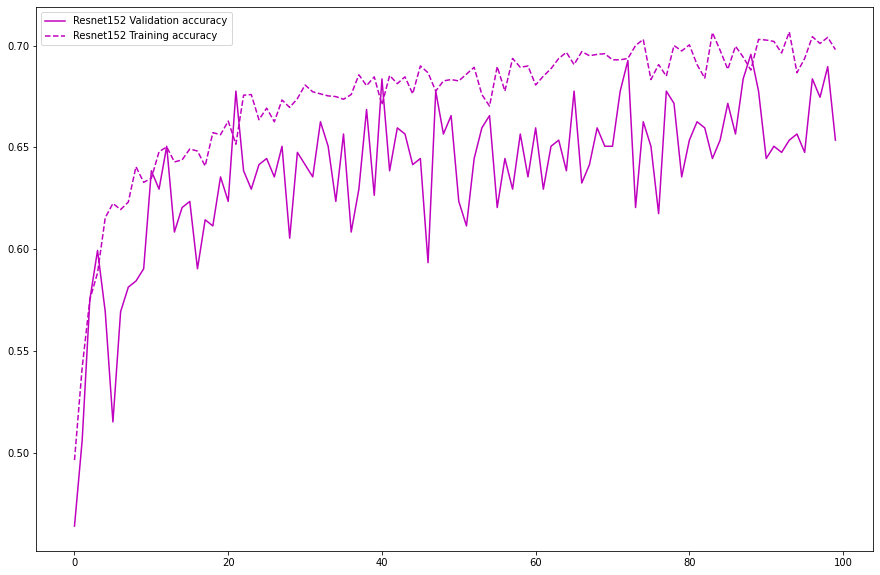

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Plotting traning and validation performance

# b_train_acc = []
# for val in balanced_tr_hist:
#   b_train_acc.append(val.cpu().data.numpy())

# b_val_acc = []
# for val in balanced_val_hist:
#   b_val_acc.append(val.cpu().data.numpy())

# b_train_acc2 = []
# for val in balanced_tr_hist2:
#   b_train_acc2.append(val.cpu().data.numpy())

# b_val_acc2 = []
# for val in balanced_val_hist2:
#   b_val_acc2.append(val.cpu().data.numpy())



# im_train_acc = []
# for val in imbalanced_tr_hist:
#   im_train_acc.append(val.cpu().data.numpy())

# im_val_acc = []
# for val in imbalanced_val_hist:
#   im_val_acc.append(val.cpu().data.numpy())
plt.figure(figsize=(15,10))
# plt.plot(b_val_acc, 'b-', label='Resnet18 Validation accuracy')
# plt.plot(b_train_acc,'b--', label='Resnet18 Training accuracy')
# plt.plot(b_val_acc2, 'g-', label='Resnet50 Validation accuracy')
# plt.plot(b_train_acc2,'g--', label='Resnet50 Training accuracy')
plt.plot(b_val_acc3, 'm-', label='Resnet152 Validation accuracy')
plt.plot(b_train_acc3,'m--', label='Resnet152 Training accuracy')
plt.legend()
plt.savefig('64_100epochs_3models.png')
plt.show()
# files.download('64_100epochs_3models.png')

In [ ]:
# path_to_save = '/content/drive/MyDrive/trained_models'
# torch.save(model_ft_balanced.state_dict(), 'model_64_100epochs_resnet18')
# torch.save(model_ft_balanced2.state_dict(), 'model_64_100epochs_resnet50')
# torch.save(model_ft_balanced3.state_dict(), 'model_64_100epochs_resnet152')
# files.download('model_64_100epochs_resnet18')
# files.download('model_64_100epochs_resnet50')
# files.download('model_64_100epochs_resnet152')

In [ ]:
test_path_data = 'drive/MyDrive/balanced_csic_data_64/testing'


transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean, std)])

testing_dataset = torchvision.datasets.ImageFolder(test_path_data, transform=transform)
batch_size = 32
testing_dataloader =torch.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
print(testing_dataset.class_to_idx)


{'Cyperus': 0, 'Negative': 1, 'Portulaca': 2, 'Solanum': 3}


In [ ]:
# send model to GPU
if torch.cuda.is_available():
    model_ft_balanced2.cuda()
    model_ft_balanced.cuda()

In [ ]:
def getTestingMetrics(dataloader, model):
  # send model to GPU
  if torch.cuda.is_available():
    model.cuda()

  # with tqdm(testing_dataloader) as tepoch:
  lbs = []
  preds = []
  #   # Iterate over data.
  for inputs, labels in dataloader:
    test_inputs = inputs.to(device)
    #test_labels = labels.to(device)
    outputs = model(test_inputs)
    _, pred = torch.max(outputs, 1)
    lbs+=(list(labels.numpy()))
    preds+= list(pred.cpu().data.numpy())
  print('Overall testing accuracy:',accuracy_score(lbs, preds))
  print(classification_report(lbs, preds, target_names=class_dict.keys()))

In [ ]:
getTestingMatrics(testing_dataloader, model_ft_balanced)
getTestingMatrics(testing_dataloader, model_ft_balanced2)
#getTestingMatrics(testing_dataloader, model_ft_balanced3)

Overall testing accuracy: 0.6258823529411764
              precision    recall  f1-score   support

     Cyperus       0.53      0.62      0.57       302
    Negative       0.69      0.81      0.75       425
   Portulaca       0.00      0.00      0.00        85
     Solanum       0.00      0.00      0.00        38

    accuracy                           0.63       850
   macro avg       0.31      0.36      0.33       850
weighted avg       0.54      0.63      0.58       850



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall testing accuracy: 0.7047058823529412
              precision    recall  f1-score   support

     Cyperus       0.62      0.84      0.71       302
    Negative       0.79      0.81      0.80       425
   Portulaca       1.00      0.01      0.02        85
     Solanum       0.33      0.03      0.05        38

    accuracy                           0.70       850
   macro avg       0.68      0.42      0.40       850
weighted avg       0.73      0.70      0.66       850

